In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree, TreeStyle
import zipfile
import re
import glob
import shutil
import os

pd.set_option("mode.chained_assignment", None)
from collections import Counter

In [2]:
full_tree_path = (
    "../trees/resolved_ALLMB_name_resolution_on_ccdb_and_tree_with_added_ccdb_names_with_missing_from_ccdb.nwk"
)
wfo_classification_path = "../wfo_classification.txt"
tpl_classification_path = "../tpl.csv"
cots_classification_path = "../chromevol/results/cots_classification/cots_classification.csv"
ploidb_family_dir = "../chromevol/with_model_weighting/by_family_on_unresolved_ALLMB_and_unresolved_ccdb/"
family_tees_roots_path = "../trees/optimal_ALLMB_roots_for_family_partition.csv"

# process tree and classification data

In [3]:
full_tree = Tree(full_tree_path, format=1)
i = 1
for node in full_tree.traverse("postorder"):
    if node.name == "1":
        node.name = f"N{i}"
        i += 1
print(f"# leaves in tree = {len(full_tree.get_leaves()):,}")

# leaves in tree = 375,581


In [4]:
wfo_classification_data = pd.read_csv(wfo_classification_path, sep="\t")
tpl_classification_data = pd.read_csv(tpl_classification_path)
wfo_accepted_classification_data = wfo_classification_data.query("taxonomicStatus == 'ACCEPTED'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
wfo_accepted_classification_data = wfo_classification_data.query("taxonomicStatus == 'ACCEPTED'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
diff = wfo_accepted_classification_data.shape[0] - tpl_accepted_classification_data.shape[0]
classification_data = wfo_accepted_classification_data if diff > 50000 else tpl_accepted_classification_data
relevant_classification_data = classification_data[["scientificName", "genus", "family", "majorGroup"]].dropna(
    how="any"
)
for c in relevant_classification_data.columns:
    relevant_classification_data[c] = relevant_classification_data[c].str.lower()
angio_data = relevant_classification_data.query("majorGroup == 'a'")

/tmp/ipykernel_9838/3961349054.py:1: DtypeWarning: Columns (2,8,9,10,12,13,14,15,16,20,21,23,24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  wfo_classification_data = pd.read_csv(wfo_classification_path, sep="\t")


In [5]:
angio_families = angio_data.family.str.lower().unique().tolist()
angio_avail_families = []
angio_species = []
for family in angio_families:
    family_tree_path = f"{ploidb_family_dir}{family}/tree.nwk"
    if os.path.exists(family_tree_path):
        angio_avail_families.append(family)
        angio_species += Tree(family_tree_path).get_leaf_names()
print(f"# species to include = {len(angio_species):,} out of {len(angio_avail_families):,} families")

# species to include = 67,153 out of 239 families


# prune tree to include only angiosperms

In [6]:
angiosperms_in_tree = set(full_tree.get_leaf_names()) & set(angio_species)
print(f"angiosperms in tree = {len(angiosperms_in_tree):,}")
full_tree.prune(angiosperms_in_tree, preserve_branch_length=True)

angiosperms in tree = 67,153


# find families MRCAs in the large angiosperms tree

In [8]:
family_to_mrca = {}
tax_to_family = {}
for family in angio_avail_families:
    family_members = Tree(f"{ploidb_family_dir}/{family}/tree.nwk").get_leaf_names()
    for member in family_members:
        tax_to_family[member] = family
    family_to_mrca[family] = full_tree.get_common_ancestor(family_members)
    assert len(family_to_mrca[family].get_leaves()) >= len(family_members)

# for each family, extract exepcted ploidization events ages. consider only events which occured in at least 75% of the mappings

In [9]:

def get_best_model(log_path: str) -> str:
    wei_re = re.compile("path=(.*?), weight=(\d*\.?\d*)", re.MULTILINE | re.DOTALL)
    best_model = ""
    best_model_weight = 0
    with open(log_path, "r") as f:
        for match in wei_re.finditer(f.read()):
            model = os.path.basename(os.path.dirname(match.group(1)))
            weight = float(match.group(2))
            if weight > best_model_weight:
                best_model_weight = weight
                best_model = model
    return best_model


def get_evolutionary_paths(sm_zip_path: str, selected_model: str, output_dir: str) -> list[str]:
    os.makedirs(output_dir, exist_ok=True)
    output_zip_path = output_dir + f"stochastic_mapping/{selected_model}/evolutionary_paths.zip"
    with zipfile.ZipFile(sm_zip_path) as archive:
        all_files = archive.namelist()
        relevant_files = [
            f
            for f in all_files
            if (
                f"stochastic_mapping/{selected_model}/evolutionary_paths" in f
                or f"stochastic_mapping/evolutionary_paths" in f
            )
            and (f.endswith(".csv") or f.endswith(".zip"))
        ]
        if len(relevant_files) == 1:
            output_zip_path = output_dir + relevant_files[0]
        for file in relevant_files:
            archive.extract(file, output_dir)
    if os.path.exists(output_zip_path) and len(os.listdir(output_dir)) <= 10:
        with zipfile.ZipFile(output_zip_path, "r") as zip_ref:
            zip_ref.extractall(output_dir)
    evolutionary_paths = (
        glob.glob(f"{output_dir}/{selected_model}/evolutionary_paths/**.csv")
        + glob.glob(f"{output_dir}/evolutionary_paths/**.csv")
        + glob.glob(f"{output_dir}/stochastic_mapping/evolutionary_paths/**.csv")
        + glob.glob(f"{output_dir}/stochastic_mapping/{selected_model}/evolutionary_paths/**.csv")
    )
    return evolutionary_paths


def parse_ploidy_ages(evolutionary_paths: str) -> pd.DataFrame:
    ploidy_ages_data = []
    for path in evolutionary_paths:
        data = pd.read_csv(path)
        data["mapping_index"] = path.split("_")[-1].split(".")[0]
        ploidy_ages_data.append(data)
    ploidy_ages_data = pd.concat(ploidy_ages_data)
    ploidy_ages_data["is_polyploidization"] = ploidy_ages_data.event_type.isin(
        ["BASE-NUMBER", "DEMI-DUPLICATION", "DUPLICATION"]
    )
    expected_ploidy_ages_data = (
        ploidy_ages_data.groupby(["branch_parent_name", "branch_child_name", "is_polyploidization"])
        .agg({"mapping_index": lambda x: len(x) / 1000, "age": lambda x: np.mean(x)})
        .reset_index()
    )
    expected_ploidy_ages_data = expected_ploidy_ages_data.rename(columns={"mapping_index": "frequency_across_mappings"})
    expected_ploidy_ages_data = expected_ploidy_ages_data.loc[
        expected_ploidy_ages_data.frequency_across_mappings >= 0.75
    ]
    return expected_ploidy_ages_data


def compute_expected_events(family: str):
    expected_ploidy_ages_data_path = f"{ploidb_family_dir}/{family}/expected_ploidy_ages_data.csv"
    sm_zip_path = f"{ploidb_family_dir}/{family}/chromevol/stochastic_mapping.zip"
    evolutionary_paths_dir = f"{ploidb_family_dir}/{family}/tmp/"

    if not os.path.exists(expected_ploidy_ages_data_path) and os.path.exists(sm_zip_path):

        # get the selected model
        selected_model = get_best_model(f"{ploidb_family_dir}/{family}/pipeline.log")
        if selected_model == "gain_loss":
            if os.path.exists(evolutionary_paths_dir):
                shutil.rmtree(evolutionary_paths_dir)
            return 0

        # extract the evolutionary paths of the best model
        evolutionary_paths = get_evolutionary_paths(
            sm_zip_path=sm_zip_path, selected_model=selected_model, output_dir=evolutionary_paths_dir
        )
        print(f"# evolutionary paths = {len(evolutionary_paths):,}")
        assert len(evolutionary_paths) >= 10
        expected_ploidy_ages_data = parse_ploidy_ages(evolutionary_paths=evolutionary_paths)
        expected_ploidy_ages_data.to_csv(expected_ploidy_ages_data_path)
        print(f"written expected ploidy ages data to {expected_ploidy_ages_data_path}")
        shutil.rmtree(evolutionary_paths_dir)


In [10]:
failed_families_to_error = {}
for family in family_to_mrca:
    try:
        compute_expected_events(family)
    except Exception as e:
        failed_families_to_error[family] = e

In [11]:
assert len(failed_families_to_error.keys()) == 0

# add internal nodes for location of events, along with the index of polyploidization (first, second third... to seventh)

In [12]:
family_to_ploidy_events = {
    family: pd.read_csv(f"{ploidb_family_dir}/{family}/expected_ploidy_ages_data.csv")
    for family in family_to_mrca
    if os.path.exists(f"{ploidb_family_dir}/{family}/expected_ploidy_ages_data.csv")
}

In [13]:
max_internal_index = np.max(
    [int(node.name.replace("N", "")) for node in full_tree.traverse() if not node.is_leaf() and not node.is_root()]
)
max_internal_index

83433

In [14]:

def parse_ml_tree(tree_path: str) -> Tree:
    tree = Tree(tree_path, format=1)
    for node in tree.traverse():
        node_name = node.name
        node_name_s = "-".join(node_name.split("-")[:-1])
        node.name = node_name_s
    if (
        len(tree.get_children()) > 2
    ):  # the node has direct children added from ccdb - remove them for visulaizayiom purposes
        for child in tree.get_children():
            if child.is_leaf():
                child.delete()
    return tree


def replace_mrca(mrca_tree: Tree, events_tree: Tree, max_internal_index: int) -> Tree:
    mrca_parent = mrca_tree.up
    mrca_dist = mrca_tree.dist
    events_tree_copy = events_tree.copy()
    for node in events_tree_copy.traverse():
        if not node.is_leaf():
            node.name = f"N{max_internal_index}"
            max_internal_index += 1
    mrca_parent.add_child(child=events_tree_copy, dist=mrca_dist)
    mrca_tree.detach()
    return events_tree_copy, max_internal_index


def map_events_to_curr_branch_names(events: pd.DataFrame, mrca_tree: Tree, events_tree: Tree) -> pd.DataFrame:
    post_order_mrca_tree = [node.name for node in mrca_tree.traverse("postorder")]
    post_order_events_tree = [node.name for node in events_tree.traverse("postorder")]
    event_to_mrca_branch_names = {
        post_order_events_tree[i]: post_order_mrca_tree[i] for i in range(len(post_order_events_tree))
    }
    events["mrca_branch_parent_name"] = events.branch_parent_name.apply(
        lambda name: event_to_mrca_branch_names.get(name, np.nan)
    )
    events["mrca_branch_child_name"] = events.branch_child_name.apply(
        lambda name: event_to_mrca_branch_names.get(name, np.nan)
    )
    leaves_events = events.loc[~events.branch_child_name.str.startswith("N", na=False)]
    if leaves_events.branch_child_name.tolist() != leaves_events.mrca_branch_child_name.tolist():
        raise ValueError(f"mapping of events and mrca branch names failed")
    return events


def add_events_to_mrca_tree(mrca_tree: Tree, polyploidizations: pd.DataFrame):
    for node in mrca_tree.traverse("preorder"):
        children = node.get_children()
        node_polyploidizations = polyploidizations.query(f"mrca_branch_parent_name == '{node.name}'")
        if node_polyploidizations.shape[0] > 0:
            for i, row in node_polyploidizations.iterrows():
                child = [child for child in children if child.name == row.mrca_branch_child_name][0]
                dist_from_node = node.get_distance(node.get_leaves()[0]) - row.age
                dist_from_child = row.age - (child.get_distance(child.get_leaves()[0]) if not child.is_leaf() else 0)
                event_subtree = child.detach()
                new_node = node.add_child(
                    name=f"polyploidization_from_{row.mrca_branch_parent_name}_to_{row.mrca_branch_child_name.replace(' ', '')}_age_{row.age}",
                    dist=dist_from_node,
                )
                new_node.add_child(child=event_subtree, dist=dist_from_child)


def add_family_events_to_full_tree(family: str, max_internal_index: int = max_internal_index):
    events = family_to_ploidy_events[family]
    events = events[[c for c in events.columns if "Unnamed" not in c]]
    events_tree_path = (
        f"{ploidb_family_dir}/{family}/chromevol/model_selection/gain_loss/MLAncestralReconstruction.tree"
    )
    events_tree = parse_ml_tree(events_tree_path)
    events = events.loc[events.branch_child_name.isin([node.name for node in events_tree.traverse()])]
    mrca_tree = family_to_mrca[family]
    mrca_tree.sort_descendants(attr="name")
    events_tree.sort_descendants(attr="name")
    post_order_mrca_tree = [node.name for node in mrca_tree.traverse("postorder")]
    post_order_events_tree = [node.name for node in events_tree.traverse("postorder")]
    if len(post_order_mrca_tree) != len(post_order_events_tree):
        # print(f"MRCA tree includes {len(post_order_mrca_tree):,} nodes while events tree includes {len(post_order_events_tree):,} nodes, will now replace it")
        mrca_tree, max_internal_index = replace_mrca(
            mrca_tree=mrca_tree, events_tree=events_tree, max_internal_index=max_internal_index
        )
        family_to_mrca[family] = mrca_tree
        mrca_tree.sort_descendants(attr="name")
    for node in mrca_tree.traverse():
        node.add_feature(pr_name="family", pr_value=family)
    events = map_events_to_curr_branch_names(events=events, mrca_tree=mrca_tree, events_tree=events_tree)
    events.to_csv(f"{ploidb_family_dir}/{family}/expected_ploidy_ages_data.csv")
    family_to_ploidy_events[family] = events
    polyploidizations = events.query("is_polyploidization").sort_values("age", ascending=False)
    add_events_to_mrca_tree(mrca_tree=mrca_tree, polyploidizations=polyploidizations)
    return max_internal_index


In [15]:
failed_family_to_error = {}
for family in family_to_mrca:
    if family in family_to_ploidy_events:
        try:
            max_internal_index = add_family_events_to_full_tree(family=family, max_internal_index=max_internal_index)
        except Exception as e:
            failed_family_to_error[family] = e

In [16]:
failed_family_to_error

{'verbenaceae': ValueError('mapping of events and mrca branch names failed'),
 'polemoniaceae': ValueError('mapping of events and mrca branch names failed'),
 'thymelaeaceae': ValueError('mapping of events and mrca branch names failed'),
 'cleomaceae': ValueError('mapping of events and mrca branch names failed')}

In [17]:
for family in failed_family_to_error:
    family_to_mrca[family].delete()

In [18]:
node_names_to_num_occurances = Counter(full_tree.get_leaf_names())
duplicated_node_names = set([l for l in node_names_to_num_occurances if node_names_to_num_occurances[l] > 1])
for node in full_tree.traverse():
    if node.name in duplicated_node_names:
        node.name = f"N{max_internal_index}"
        max_internal_index += 1

# document the order of polyploidzation since the root

In [19]:
full_tree.add_feature(pr_name="num_prev_polyploidizations", pr_value=0)
for node in full_tree.traverse("preorder"):
    poly_index = node.num_prev_polyploidizations
    if node.name.startswith("polyploidization"):
        poly_index += 1
        node.add_feature(pr_name="polyploidization_index", pr_value=poly_index)
    for child in node.get_children():
        child.add_feature(pr_name="num_prev_polyploidizations", pr_value=poly_index)

In [20]:
print(f"# leaves in tree = {len(full_tree.get_leaves()):,}")
poy_indices = [
    node.polyploidization_index for node in full_tree.traverse("preorder") if node.name.startswith("polyploidization")
]
print(f"# polyplodizations along tree = {len(poy_indices):,}")
print(f"maximal number of events along evolutionary paths = {np.max(poy_indices)}")

# leaves in tree = 66,406
# polyplodizations along tree = 16,431
maximal number of events along evolutionary paths = 5


In [21]:
full_tree.write(
    outfile="ALLMB_angiosperms_tree_with_polyploidizations.nwk",
    format=1,
    features=["family", "num_prev_polyploidizations", "polyploidization_index"],
)

# add to nodes their cots classification

In [22]:
cots_classification = pd.read_csv(cots_classification_path)

In [23]:
cots_classification.family = cots_classification.family.str.lower()
family_to_clade = (
    cots_classification.dropna(subset=["family"])
    .set_index("family")["Major phylogeny groups according to Wood et al. 2009"]
    .to_dict()
)

In [26]:
tips_wo_clade_class, leaves_wo_families = [], []
for leaf in full_tree.get_leaves():
    if "family" not in leaf.__dict__["features"] and leaf.name in tax_to_family:
        leaf.add_feature(pr_name="family", pr_value=tax_to_family[leaf.name])
    clade = family_to_clade.get(leaf.family, np.nan)
    leaf.add_feature(pr_name="clade", pr_value=clade)
    if pd.isna(clade):
        tips_wo_clade_class.append(leaf.name)

In [49]:
for node in full_tree.traverse("postorder"):
    if node.is_leaf():
        continue
    children_clades = list(set([child.clade for child in node.get_leaves()]))
    node.add_feature(pr_name="clade", pr_value=children_clades)

In [50]:
full_tree.write(
    outfile="ALLMB_angiosperms_tree_with_polyploidizations.nwk",
    format=1,
    features=["family", "num_prev_polyploidizations", "polyploidization_index", "clade"],
)

# add leaves classifization to orders

In [5]:
tree = Tree("ALLMB_angiosperms_tree_with_polyploioidizations.nwk", format=1)
clade_classification_data = pd.read_csv(cots_classification_path)

In [8]:
clade_classification_data.tax_name = clade_classification_data.tax_name.str.lower()
leaf_to_order = clade_classification_data.dropna(subset=["tax_name", "order"]).set_index("tax_name")["order"].to_dict()

In [9]:
for leaf in tree.traverse():
    leaf.add_feature(pr_name="order", pr_value=leaf_to_order.get(leaf.name, np.nan))

In [11]:
tree.write(
    outfile="ALLMB_angiosperms_tree_with_polyploioidizations.nwk",
    format=1,
    features=["family", "num_prev_polyploidizations", "polyploidization_index", "clade", "order"],
)

# collapse all subtrees following thr last polyploidization in their evolutionary path

In [1]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace, CircleFace
import matplotlib.colors as mcolors
import pylab

import os

os.environ["QT_QPA_PLATFORM"] = "offscreen"

color_by_cat = True
tree_per_clade = True
collapse = False

In [2]:
tree = Tree("ALLMB_angiosperms_tree_with_polyploioidizations.nwk", format=1)
print(f"# polyplodizations = {len([n for n in tree.traverse() if n.name.startswith('polyploidization')]):,}")
tree.get_tree_root().add_feature(pr_name="num_prev_polyploidizations", pr_value=0)
tree.convert_to_ultrametric()

# polyplodizations = 16,431


In [3]:
if collapse:
    for node in tree.traverse("preorder"):
        if int(node.num_prev_polyploidizations) == max([int(l.num_prev_polyploidizations) for l in node.get_leaves()]):
            for child in node.get_children():
                node.remove_child(child)
    print(f"# polyplodizations = {len([n for n in tree.traverse() if n.name.startswith('polyploidization')]):,}")
    print(f"# leaves = {len(tree.get_leaves()):,}")

In [4]:
clades = list(set([l.clade for l in tree.get_leaves()]))
clade_to_size = {c: len([l for l in tree.get_leaves() if l.clade == c]) for c in clades}
clades.sort(key=lambda c: clade_to_size[c])
poly_index_to_color = {0: "silver", 1: "#a1dab4", 2: "#41b6c4", 3: "#2c7fb8", 4: "#253494", 5: "midnightblue"}

In [8]:

def get_tree_style(tree, color_by_cat: bool):
    ts = TreeStyle()
    ts.mode = "c"  # draw tree in circular mode
    ts.scale = None
    ts.optimal_scale_level = "full"
    ts.extra_branch_line_type = 0
    # ts.force_topology  = True
    ts.show_leaf_name = False
    ts.show_scale = False
    ts.margin_top = 10
    ts.margin_right = 10
    ts.margin_left = 10
    ts.margin_bottom = 10

    cat_to_color = {}
    cat_name = "order" if tree_per_clade else "order"
    if color_by_cat:
        colors = list(mcolors.XKCD_COLORS.values())
        categories = list(set([l.__dict__[cat_name] for l in tree.get_leaves()]))
        for i in range(len(categories)):
            cat_to_color[categories[i]] = colors[i * 10]
            cat_to_color["nan"] = "white"

    nleaves = len(tree.get_leaves())
    rect_scale = 2 if nleaves < 1000 else (20 if nleaves < 10000 else 10)
    for n in tree.traverse():
        node_color = poly_index_to_color[int(n.num_prev_polyploidizations)]
        if "family" not in n.__dict__["features"]:
            node_color = "gainsboro"
        node_cat_color = node_color
        if n.is_leaf() and color_by_cat:
            node_cat_color = cat_to_color.get(n.__dict__[cat_name], "white")
        nstyle = NodeStyle()
        nstyle["hz_line_color"] = node_color
        nstyle["vt_line_color"] = node_color
        nstyle["vt_line_width"] = 10
        nstyle["hz_line_width"] = 10
        nstyle["bgcolor"] = "white"
        nstyle["size"] = 500 * rect_scale if (color_by_cat and n.is_leaf()) else 0.01
        nstyle["shape"] = "square"
        nstyle["fgcolor"] = node_cat_color
        if n.is_leaf() and color_by_cat:
            n.img_style["size"] = 500 * rect_scale
            n.img_style["shape"] = "square"
            n.img_style["fgcolor"] = node_cat_color
        n.set_style(nstyle)

    if color_by_cat:
        for cat in cat_to_color:
            if cat == "nan":
                continue
            color = cat_to_color[cat]
            ts.legend.add_face(
                face=RectFace(35 * rect_scale, 35 * rect_scale, fgcolor="white", bgcolor="white", label=""), column=1
            )
            text = f"{cat}{''.join([' ']*(60-len(cat)))}"
            ts.legend.add_face(
                face=RectFace(
                    25 * rect_scale,
                    10 * rect_scale,
                    fgcolor=color,
                    bgcolor=color,
                    label={
                        "fontsize": 25 * rect_scale,
                        "text": text,
                        "color": "black" if cat != "nan" else "white",
                    },
                ),
                column=1,
            )
        for poly_index in poly_index_to_color:
            ts.legend.add_face(
                face=RectFace(35 * rect_scale, 35 * rect_scale, fgcolor="white", bgcolor="white", label=""), column=1
            )
            text = f"{poly_index}th polyploidization"
            ts.legend.add_face(
                face=RectFace(
                    25 * rect_scale,
                    10 * rect_scale,
                    fgcolor="white",
                    bgcolor=poly_index_to_color[poly_index],
                    label={
                        "fontsize": 25 * rect_scale,
                        "text": f"{text}{''.join([' ']*(60-len(text)))}",
                        "color": "black",
                    },
                ),
                column=1,
            )

    return ts


plotting trees with coloring

# leaves in Basal angiosperms = 689

# leaves in Higher monocots _commelinids_ = 6,813

# leaves in Basal dicots _non-asterid +non-rosid dicots_ = 7,824

# leaves in Basal monocots _non-commelinid monocots_ = 8,306

# leaves in Dicots - core rosids = 16,212

# leaves in Dicots - core asterids = 26,441


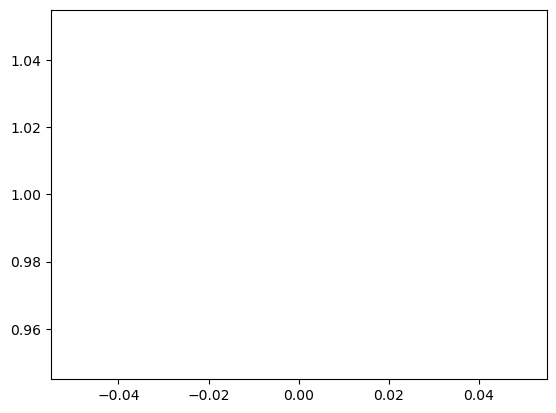

<Figure size 300x3000 with 0 Axes>

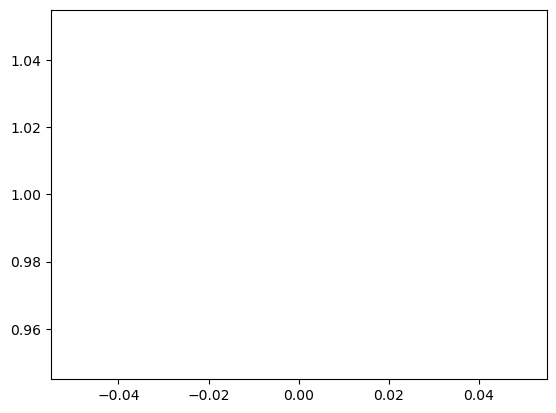

<Figure size 300x3000 with 0 Axes>

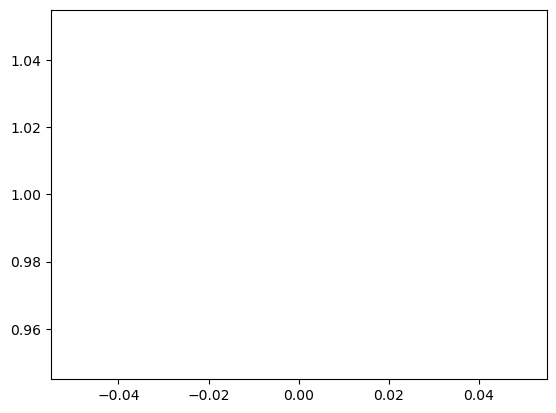

<Figure size 300x3000 with 0 Axes>

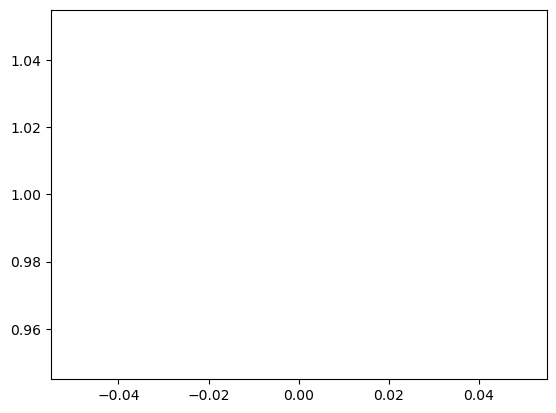

<Figure size 300x3000 with 0 Axes>

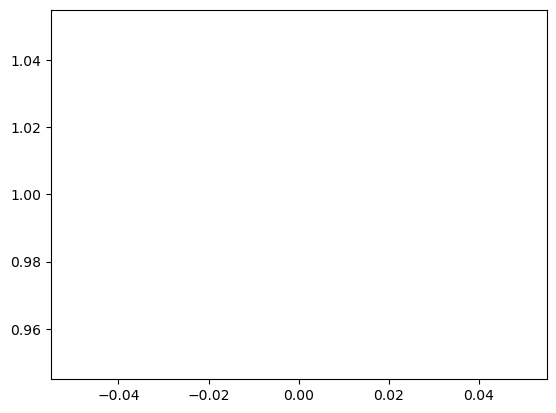

<Figure size 300x3000 with 0 Axes>

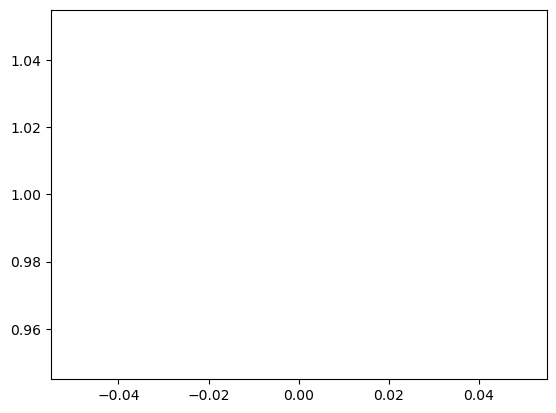

<Figure size 300x3000 with 0 Axes>

In [9]:
print(f"plotting trees with coloring")
for clade in clades:
    if clade == "nan":
        continue
    node = tree.copy()
    node.prune([l.name for l in tree.get_leaves() if l.clade == clade], preserve_branch_length=True)
    print(f"\n# leaves in {clade} = {len(node.get_leaves()):,}")
    node.write(
        outfile=f"{clade.replace(' ', '_')}_tree.nwk",
        format=1,
        features=["family", "num_prev_polyploidizations", "polyploidization_index", "clade", "order"],
    )
    node.convert_to_ultrametric()
    ts = get_tree_style(node, color_by_cat=False)
    node.render(f"{clade.replace(' ','_')}_tree_wo_color_by_cat.jpeg", tree_style=ts, w=1000, h=1000)

    if color_by_cat:
        cat_to_color = {}
        cat_name = "order" if tree_per_clade else "order"
        fig = pylab.figure()
        figlegend = pylab.figure(figsize=(3, 30))
        ax = fig.add_subplot(111)

        if color_by_cat:
            colors = list(mcolors.XKCD_COLORS.values())
            categories = list(set([l.__dict__[cat_name] for l in tree.get_leaves()]))
            for i in range(len(categories)):
                if categories[i] == "nan":
                    continue
                cat_to_color[categories[i]] = colors[i * 10]
        for cat in categories:
            if cat != "nan":
                ax.plot([1], color=cat_to_color[cat], label=cat)
        for poly_index in poly_index_to_color:
            ax.plot(
                [1],
                color=poly_index_to_color[poly_index],
                label=f"{poly_index}{'st' if poly_index == 1 else 'th'} polyploidization",
            )

        h, l = ax.get_legend_handles_labels()
        figlegend.legend(h, l)
        figlegend.tight_layout()
        figlegend.savefig(f"{clade.replace(' ', '_')}_legend.pdf")

In [10]:
print(f"plotting trees without coloring")
for clade in clades:
    if clade == "nan":
        continue
    node = tree.copy()
    node.prune([l.name for l in tree.get_leaves() if l.clade == clade], preserve_branch_length=True)
    print(f"\n# leaves in {clade} = {len(node.get_leaves()):,}")
    node.write(
        outfile=f"{clade.replace(' ', '_')}_tree.nwk",
        format=1,
        features=["family", "num_prev_polyploidizations", "polyploidization_index", "clade", "order"],
    )
    node.convert_to_ultrametric()
    ts = get_tree_style(node, color_by_cat=True)
    node.render(f"{clade.replace(' ','_')}_tree_w_color_by_cat.pdf", tree_style=ts, w=1000, h=1000)

plotting trees without coloring

# leaves in Basal angiosperms = 689

# leaves in Higher monocots _commelinids_ = 6,813

# leaves in Basal dicots _non-asterid +non-rosid dicots_ = 7,824

# leaves in Basal monocots _non-commelinid monocots_ = 8,306

# leaves in Dicots - core rosids = 16,212

# leaves in Dicots - core asterids = 26,441
